# Loan Default Risk Analysis

# Data Cleaning

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load the Dataset

In [5]:
df = pd.read_csv("C:/Users/khush/OneDrive/Desktop/loan_default_analysis.csv")

## Step 3: Initial Dataset Overview

In [6]:
df.shape

(38480, 37)

In [7]:
df.head()

,1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,...,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,repay_fail
0,2,2,2,0.0,0.0,0.0,36 months,0.00,0.00,< 1 year,...,1.0,0.000000,0.00,0.00,0.00,Jan-07,0.00,Jan-07,Jan-07,1
1,3,545583,703644,2500.0,2500.0,2500.0,36 months,13.98,85.42,4 years,...,10.0,3075.291779,3075.29,2500.00,575.29,Jul-13,90.85,Aug-13,Jun-16,0
2,4,532101,687836,5000.0,5000.0,5000.0,36 months,15.95,175.67,4 years,...,15.0,2948.760000,2948.76,1909.02,873.81,Nov-11,175.67,NaN,Mar-12,1
3,5,877788,1092507,7000.0,7000.0,7000.0,36 months,9.91,225.58,10+ years,...,20.0,8082.391880,8082.39,7000.00,1082.39,Mar-14,1550.27,NaN,Mar-14,0
4,6,875406,1089981,2000.0,2000.0,2000.0,36 months,5.42,60.32,10+ years,...,15.0,2161.663244,2161.66,2000.00,161.66,Feb-14,53.12,NaN,Jun-16,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38475 entries, 0 to 38479
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   loan_amnt               38475 non-null  float64       
 1   funded_amnt             38475 non-null  float64       
 2   funded_amnt_inv         38475 non-null  float64       
 3   term                    38475 non-null  int32         
 4   int_rate                38475 non-null  float64       
 5   installment             38475 non-null  float64       
 6   emp_length              38475 non-null  float64       
 7   home_ownership          38475 non-null  object        
 8   annual_inc              38475 non-null  float64       
 9   verification_status     38475 non-null  object        
 10  issue_d                 38475 non-null  datetime64[ns]
 11  purpose                 38475 non-null  object        
 12  addr_state              38475 non-null  object

### ✅ Insights from `df.info()`

The dataset contains **38,480 loan records** and **37 columns**, indicating a moderately large portfolio dataset suitable for credit risk and loan default analysis.

#### **1) Data Structure & Types**
- The dataset includes a combination of:
  - **Numerical variables** (loan amounts, interest rate, DTI, revolving balances, credit account counts)
  - **Categorical variables** (term, purpose, home ownership, verification status, state)
  - **Date-related variables stored as object** (issue date, earliest credit line, last payment dates)

This mix of variables suggests the dataset captures both **loan design** and **borrower credit behaviour**, which are key components of default risk analysis.

#### **2) Target Variable Availability**
- The column **`repay_fail`** is present as an integer (0/1), making it a clear binary target variable for identifying repayment failure cases.

#### **3) Missing Values (Initial Observations)**
Most columns are highly complete. However, noticeable missingness exists in:
- **`mths_since_last_delinq`** (large missing count)
- **`next_pymnt_d`** (large missing count)

These are expected in real loan datasets because:
- Many borrowers may have **no delinquency history**, leading to missing `mths_since_last_delinq`
- `next_pymnt_d` is often unavailable for loans that are already closed or charged off

Minor missing values are also seen in:
- `emp_length`, `revol_util`, `revol_bal`, and a few numeric fields

#### **4) Presence of Post-Loan (Leakage) Variables**
The dataset includes repayment outcome-related columns such as:
- `total_pymnt`, `total_rec_prncp`, `total_rec_int`
- `last_pymnt_d`, `last_pymnt_amnt`, `next_pymnt_d`

These variables are generated **after the loan is issued**, meaning they may directly reveal repayment behaviour.
Therefore, they will be treated as **leakage features** and excluded from default driver analysis to keep the project realistic and unbiased.

#### **5) Next Steps Based on `df.info()`**
The dataset requires:
- Data type corrections (especially for date columns)
- Handling missing values appropriately
- Removing leakage columns before SQL and EDA
- Standardizing key categorical variables for clean grouping analysis


In [9]:
df["repay_fail"].value_counts()

0    32651
1     5829
Name: repay_fail, dtype: int64

In [10]:
df["repay_fail"].value_counts(normalize=True) * 100

0    84.851871
1    15.148129
Name: repay_fail, dtype: float64

### ✅ Insights from `repay_fail.value_counts()`

The target variable **`repay_fail`** represents loan repayment failure, where:
- **0 = Non-default / repayment successful**
- **1 = Default / repayment failure**

From the distribution:
- **32,651 loans** are non-default cases (`repay_fail = 0`)
- **5,829 loans** are default cases (`repay_fail = 1`)

This indicates that the dataset contains a substantial number of both default and non-default loans, making it suitable for comparative default risk analysis.


## Step 4: Missing Values Audit

In [11]:
missing_table = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_percent": (df.isna().sum() / len(df)) * 100
}).sort_values(by="missing_percent", ascending=False)

missing_table.head(20)

,missing_count,missing_percent
next_pymnt_d,35097,91.208420
mths_since_last_delinq,24363,63.313410
emp_length,993,2.580561
last_pymnt_d,71,0.184511
revol_util,59,0.153326
revol_bal,4,0.010395
last_credit_pull_d,3,0.007796
annual_inc,2,0.005198
installment,1,0.002599
last_pymnt_amnt,1,0.002599


In [13]:
df.describe()

,1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,...,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,repay_fail
count,38480.000000,3.848000e+04,3.848000e+04,38479.000000,38479.000000,38479.000000,38480.00000,38479.000000,3.847800e+04,38480.000000,...,38479.000000,38479.000000,3.847600e+04,38479.000000,38479.000000,38479.000000,38479.000000,38479.000000,38479.000000,38480.000000
mean,19240.500000,6.649979e+05,8.261899e+05,11094.727644,10831.856337,10150.141518,12.16430,323.163255,6.899531e+04,13.378119,...,9.342966,0.057902,1.428987e+04,22.108501,11980.696892,11274.519569,9646.412705,2232.768235,2614.441757,0.151481
std,11108.363516,2.192322e+05,2.793531e+05,7405.416042,7146.853682,7128.026828,3.73744,209.089097,6.447639e+04,6.744356,...,4.498075,0.245707,2.194138e+04,11.588602,9006.505205,8946.229941,7051.828302,2570.177312,4391.969583,0.358522
min,1.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9620.750000,4.983645e+05,6.384620e+05,5200.000000,5100.000000,4950.000000,9.62000,165.740000,4.000000e+04,8.200000,...,6.000000,0.000000,3.639750e+03,13.000000,5463.099238,4811.735000,4400.000000,657.700000,212.010000,0.000000
50%,19240.500000,6.443195e+05,8.242545e+05,9750.000000,9600.000000,8495.792749,11.99000,277.980000,5.865000e+04,13.485000,...,9.000000,0.000000,8.839500e+03,20.000000,9673.221341,8953.240000,8000.000000,1335.090000,526.000000,0.000000
75%,28860.250000,8.265608e+05,1.034706e+06,15000.000000,15000.000000,14000.000000,14.72000,429.350000,8.200000e+04,18.690000,...,12.000000,0.000000,1.726550e+04,29.000000,16402.394995,15486.925000,13315.100000,2795.020000,3169.815000,0.000000
max,38480.000000,1.077430e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,100.99000,1305.190000,6.000000e+06,100.000000,...,47.000000,5.000000,1.207359e+06,90.000000,58563.679930,58563.680000,35000.020000,23611.100000,36115.200000,1.000000


In [14]:
df["int_rate"].head(5)

0     0.00
1    13.98
2    15.95
3     9.91
4     5.42
Name: int_rate, dtype: float64

## Step 5: Fix Format Issues + Clean Key Columns

In [15]:
df["term"].value_counts()

36 months    28593
60 months     9887
Name: term, dtype: int64

In [16]:
df["term"] = df["term"].str.replace(" months", "", regex=False).astype(int)

In [17]:
df["emp_length"].value_counts(dropna=False)

10+ years    8465
< 1 year     4565
2 years      4292
3 years      3939
4 years      3314
1 year       3254
5 years      3171
6 years      2144
7 years      1702
8 years      1445
9 years      1196
NaN           993
Name: emp_length, dtype: int64

In [18]:
df["emp_length"] = df["emp_length"].str.strip()

df["emp_length"] = df["emp_length"].replace({
    "10+ years": "10",
    "< 1 year": "0"
})

df["emp_length"] = df["emp_length"].str.replace(" years", "", regex=False)
df["emp_length"] = df["emp_length"].str.replace(" year", "", regex=False)

df["emp_length"] = pd.to_numeric(df["emp_length"], errors="coerce")

In [19]:
(df["int_rate"] == 0).sum()

1

In [20]:
df.loc[df["int_rate"] == 0, "int_rate"] = np.nan

In [21]:
df["revol_util"].head(10)

0    “0.00%”
1     21.30%
2     99.90%
3     47.20%
4         0%
5         0%
6     13.60%
7     47.70%
8     70.80%
9     98.70%
Name: revol_util, dtype: object

In [22]:
df["revol_util"] = df["revol_util"].astype(str).str.replace("%", "", regex=False)
df["revol_util"] = pd.to_numeric(df["revol_util"], errors="coerce")

In [23]:
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%y", errors="coerce")
df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%y", errors="coerce")
df["last_pymnt_d"] = pd.to_datetime(df["last_pymnt_d"], format="%b-%y", errors="coerce")
df["next_pymnt_d"] = pd.to_datetime(df["next_pymnt_d"], format="%b-%y", errors="coerce")
df["last_credit_pull_d"] = pd.to_datetime(df["last_credit_pull_d"], format="%b-%y", errors="coerce")

In [24]:
df[["term", "emp_length", "int_rate", "revol_util", "issue_d", "earliest_cr_line"]].head()

,term,emp_length,int_rate,revol_util,issue_d,earliest_cr_line
0,36,0.0,NaN,NaN,1999-12-01,2001-01-01
1,36,4.0,13.98,21.3,2010-07-01,2005-08-01
2,36,4.0,15.95,99.9,2010-06-01,1994-04-01
3,36,10.0,9.91,47.2,2011-09-01,1998-03-01
4,36,10.0,5.42,0.0,2011-09-01,1975-01-01


## Step 6: Remove Leakage Columns + Final Missing Value Strategy

### ✅ Removing post-loan (leakage) columns
Some columns contain information that becomes available only after the loan is issued and repayments begin.
These variables can leak the outcome and will not be used for default driver analysis.

In [25]:
leakage_cols = [
    "loan_status",
    "total_pymnt", "total_pymnt_inv",
    "total_rec_prncp", "total_rec_int",
    "last_pymnt_d", "last_pymnt_amnt",
    "next_pymnt_d",
    "last_credit_pull_d"
]

df = df.drop(columns=leakage_cols, errors="ignore")

### ✅ Dropping identifiers
IDs are not useful as analysis predictors and add no business interpretation.

In [26]:
id_cols = ["id", "member_id", "zip_code","1"]
df = df.drop(columns=id_cols, errors="ignore")


In [27]:
df["mths_since_last_delinq"] = df["mths_since_last_delinq"].fillna(-1)

In [28]:
df = df.dropna(subset=["loan_amnt", "funded_amnt", "funded_amnt_inv", "installment", 
                       "annual_inc", "dti", "delinq_2yrs", "inq_last_6mths", 
                       "open_acc", "pub_rec", "revol_bal"])

In [29]:
df.shape

(38475, 24)

In [30]:
df.isna().sum().sort_values(ascending=False).head(15)

emp_length                993
revol_util                 60
int_rate                    1
loan_amnt                   0
dti                         0
total_acc                   0
revol_bal                   0
pub_rec                     0
open_acc                    0
mths_since_last_delinq      0
inq_last_6mths              0
earliest_cr_line            0
delinq_2yrs                 0
addr_state                  0
funded_amnt                 0
dtype: int64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38475 entries, 0 to 38479
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   loan_amnt               38475 non-null  float64       
 1   funded_amnt             38475 non-null  float64       
 2   funded_amnt_inv         38475 non-null  float64       
 3   term                    38475 non-null  int32         
 4   int_rate                38474 non-null  float64       
 5   installment             38475 non-null  float64       
 6   emp_length              37482 non-null  float64       
 7   home_ownership          38475 non-null  object        
 8   annual_inc              38475 non-null  float64       
 9   verification_status     38475 non-null  object        
 10  issue_d                 38475 non-null  datetime64[ns]
 11  purpose                 38475 non-null  object        
 12  addr_state              38475 non-null  object

## Step 7: Final Missing Handling + Standardization 

In [32]:
df["emp_length"] = df["emp_length"].fillna(df["emp_length"].median())
df["revol_util"] = df["revol_util"].fillna(df["revol_util"].median())
df["int_rate"] = df["int_rate"].fillna(df["int_rate"].median())

In [33]:
cat_cols = ["home_ownership", "verification_status", "purpose", "addr_state"]

for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

In [34]:
df.isna().sum().sort_values(ascending=False).head(15)

loan_amnt                 0
funded_amnt               0
total_acc                 0
revol_util                0
revol_bal                 0
pub_rec                   0
open_acc                  0
mths_since_last_delinq    0
inq_last_6mths            0
earliest_cr_line          0
delinq_2yrs               0
dti                       0
addr_state                0
purpose                   0
issue_d                   0
dtype: int64

In [35]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,repay_fail
0,0.0,0.0,0.0,36,11.99,0.00,0.0,rent,0.0,not verified,...,0.0,2001-01-01,0.0,-1.0,0.0,0.0,0.0,49.6,1.0,1
1,2500.0,2500.0,2500.0,36,13.98,85.42,4.0,rent,20004.0,not verified,...,0.0,2005-08-01,5.0,-1.0,7.0,0.0,981.0,21.3,10.0,0
2,5000.0,5000.0,5000.0,36,15.95,175.67,4.0,rent,59000.0,not verified,...,0.0,1994-04-01,1.0,59.0,7.0,0.0,18773.0,99.9,15.0,1
3,7000.0,7000.0,7000.0,36,9.91,225.58,10.0,mortgage,53796.0,not verified,...,3.0,1998-03-01,3.0,3.0,7.0,0.0,3269.0,47.2,20.0,0
4,2000.0,2000.0,2000.0,36,5.42,60.32,10.0,rent,30000.0,not verified,...,0.0,1975-01-01,0.0,72.0,7.0,0.0,0.0,0.0,15.0,0


## Step 8: Export the Cleaned Dataset for SQL Analysis

In [37]:
df.to_csv("loan_default_cleaned.csv", index=False)

# Phase 3: Exploratory Data Analysis (EDA)
## Step 1: Setup and Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load Clean Dataset and Validate Structure

In [3]:
df = pd.read_csv("C:/Users/khush/OneDrive/Desktop/loan_default_cleaned.csv")
df.shape

(38474, 24)

In [3]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,repay_fail
0,2500,2500,2500.0,36,13.98,85.42,4,rent,20004.0,not verified,...,0,01-08-2005,5,-1,7,0,981,21.3,10,0
1,5000,5000,5000.0,36,15.95,175.67,4,rent,59000.0,not verified,...,0,01-04-1994,1,59,7,0,18773,99.9,15,1
2,7000,7000,7000.0,36,9.91,225.58,10,mortgage,53796.0,not verified,...,3,01-03-1998,3,3,7,0,3269,47.2,20,0
3,2000,2000,2000.0,36,5.42,60.32,10,rent,30000.0,not verified,...,0,01-01-1975,0,72,7,0,0,0.0,15,0
4,3600,3600,3600.0,36,10.25,116.59,10,mortgage,675048.0,not verified,...,0,01-04-1998,4,25,8,0,0,0.0,25,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38474 entries, 0 to 38473
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               38474 non-null  int64  
 1   funded_amnt             38474 non-null  int64  
 2   funded_amnt_inv         38474 non-null  float64
 3   term                    38474 non-null  int64  
 4   int_rate                38474 non-null  float64
 5   installment             38474 non-null  float64
 6   emp_length              38474 non-null  int64  
 7   home_ownership          38474 non-null  object 
 8   annual_inc              38474 non-null  float64
 9   verification_status     38474 non-null  object 
 10  issue_d                 38474 non-null  object 
 11  purpose                 38474 non-null  object 
 12  addr_state              38474 non-null  object 
 13  dti                     38474 non-null  float64
 14  delinq_2yrs             38474 non-null

### ✅ Insights (Dataset Structure)
- Total rows:38474
- Total columns:24
- Target variable: `repay_fail` (0 = No Default, 1 = Default)
- Numeric vs categorical columns verified successfully

## Step 3: Target Variable Distribution (Repayment Failure Rate)

In [5]:
df["repay_fail"].value_counts()

0    32648
1     5826
Name: repay_fail, dtype: int64

In [6]:
df["repay_fail"].value_counts(normalize=True) * 100

0    84.857306
1    15.142694
Name: repay_fail, dtype: float64

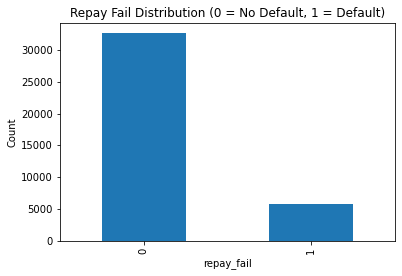

In [7]:
df["repay_fail"].value_counts().plot(kind="bar")
plt.title("Repay Fail Distribution (0 = No Default, 1 = Default)")
plt.xlabel("repay_fail")
plt.ylabel("Count")
plt.show()

The dataset reflects a realistic lending portfolio structure, where repayment failures are fewer than successful repayments, making default analysis a minority-class risk investigation.


## Step 4: Summary Statistics (Numerical Variables)

In [8]:
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,repay_fail
count,38474.000000,38474.000000,38474.000000,38474.000000,38474.000000,38474.000000,38474.000000,3.847400e+04,38474.000000,38474.000000,38474.000000,38474.000000,38474.000000,38474.000000,3.847400e+04,38474.000000,38474.000000,38474.000000
mean,11095.657457,10832.751988,10150.948575,42.166242,12.162205,323.189393,4.898347,6.899827e+04,13.376666,0.151921,1.083901,12.209648,9.343271,0.057909,1.429061e+04,49.114121,22.109269,0.151427
std,7405.368983,7146.804287,7128.056287,10.486664,3.709353,209.087452,3.521556,6.447851e+04,6.729761,0.507604,1.534815,22.038444,4.497964,0.245722,2.194171e+04,28.330500,11.588483,0.358469
min,500.000000,500.000000,0.000000,36.000000,5.420000,15.670000,0.000000,1.896000e+03,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000
25%,5200.000000,5100.000000,4950.000000,36.000000,9.620000,165.740000,2.000000,4.000000e+04,8.200000,0.000000,0.000000,-1.000000,6.000000,0.000000,3.640250e+03,25.800000,13.000000,0.000000
50%,9762.500000,9600.000000,8499.714442,36.000000,11.990000,278.005000,4.000000,5.865000e+04,13.490000,0.000000,1.000000,-1.000000,9.000000,0.000000,8.840000e+03,49.600000,20.000000,0.000000
75%,15000.000000,15000.000000,14000.000000,60.000000,14.720000,429.372500,9.000000,8.200000e+04,18.690000,0.000000,2.000000,21.000000,12.000000,0.000000,1.726650e+04,72.600000,29.000000,0.000000
max,35000.000000,35000.000000,35000.000000,60.000000,24.110000,1305.190000,10.000000,6.000000e+06,29.990000,11.000000,33.000000,120.000000,47.000000,5.000000,1.207359e+06,119.000000,90.000000,1.000000


### ✅ Insights: Numerical Summary Statistics (Portfolio Overview)

The summary statistics provide a baseline understanding of loan exposure, pricing, borrower affordability, and credit behaviour.

#### 1) Loan Amount & Funding
- The average loan amount (`loan_amnt`) is approximately **11,096**, while the average funded amount (`funded_amnt`) is approximately **10,833**.
- This indicates that the **funded amount is slightly lower than the requested loan amount**, suggesting that some loans may have been partially funded or adjusted at approval stage.
- Loan amounts range from **500 to 35,000**, confirming a portfolio with both small-ticket and high-ticket loans.

#### 2) Term Structure (Loan Duration)
- Loans are primarily issued for **36 and 60 months**, with the median term being **36 months**.

#### 3) Pricing (Interest Rate and Installment)
- Interest rates range from approximately **5.42% to 24.11%**, highlighting strong risk-based pricing.
- The average interest rate is around **12.16%**, with a median near **11.99%**, suggesting most loans are clustered around mid-range rates.
- Monthly installment values show a wide range (min around **15.67** and max around **1305.19**), indicating that repayment burden varies significantly across borrowers.

#### 4) Employment and Income (Affordability Drivers)
- The average employment length (`emp_length`) is around **4.9 years**, with values capped at **10 years** due to cleaning logic.
- Annual income (`annual_inc`) has a median around **58,650** but a very high maximum (**6,000,000**), indicating the presence of strong income outliers.
- The income distribution is therefore highly right-skewed and may require outlier treatment or log scaling during visual EDA.

#### 5) Debt Burden (DTI)
- The average DTI is around **13.38**, with values ranging from **0 to 29.99**.
- This suggests that most borrowers fall under moderate debt burden levels, while some borrowers show high repayment stress.

#### 6) Delinquency History & Credit Seeking Behaviour
- Most borrowers have **0 delinquencies in the past 2 years** (median = 0), but the maximum reaches **11**, indicating some high-risk credit histories.
- The average number of credit inquiries in the last 6 months is around **1.08**, but the maximum goes up to **33**, which may represent credit-hungry or distressed borrowers.

#### 7) Credit Exposure & Utilization
- Revolving balance (`revol_bal`) has a median around **8,840**, but a very high maximum (~**1,207,359**), indicating extreme outliers.
- Revolving utilization (`revol_util`) has a median around **49.6%**, with the upper range exceeding **100%**, suggesting potential anomalies or over-limit utilisation behaviour that should be reviewed.
- Total accounts (`total_acc`) shows a median around **20** with values up to **90**, representing variability in credit depth.

#### 8) Target Variable Summary
- The mean value of `repay_fail` is approximately **0.151**, confirming that the portfolio default rate is around **15%**, consistent with earlier target distribution analysis.


## Step 6: Univariate Distribution Analysis (Key Risk Variables)

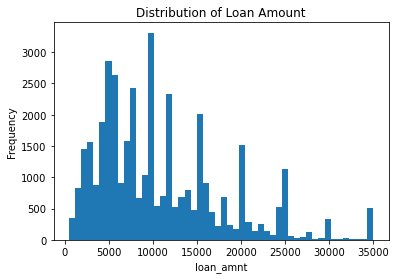

In [20]:
plt.hist(df["funded_amnt"], bins=50)
plt.title("Distribution of Loan Amount")
plt.xlabel("loan_amnt")
plt.ylabel("Frequency")
plt.show()

### ✅ Insights: Distribution of Funded Amount (`funded_amnt`)

- The distribution of `funded_amnt` is **right-skewed**, meaning most loans are concentrated at **lower to mid loan values**, while fewer loans exist at very high amounts.
- A large portion of loans appear to fall roughly within the **₹/ $2,000 to ₹/ $15,000 range**, indicating that the portfolio is dominated by **small-to-medium ticket loans**.
- The frequency gradually declines as loan amount increases, showing that **high-value loans are less common** in the portfolio.
- The distribution shows visible “spikes” at certain loan values (for example around 5k, 10k, 15k etc.), which suggests that loan amounts may be issued in **standardized slabs or rounded increments** rather than being continuous random values.
- Since loan size represents the lender’s **exposure**, higher loan amounts may contribute to larger potential losses if repayment fails, making loan amount an important variable for risk segmentation.


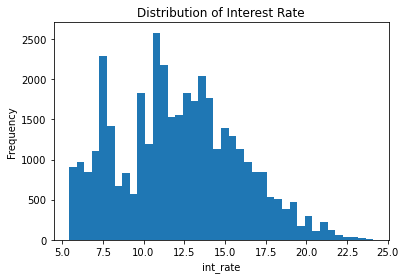

In [10]:
plt.hist(df["int_rate"], bins=40)
plt.title("Distribution of Interest Rate")
plt.xlabel("int_rate")
plt.ylabel("Frequency")
plt.show()

### ✅ Insights: Distribution of Interest Rate (`int_rate`)

- The distribution of `int_rate` lies approximately between **5% and 25%**, indicating that loans are priced across a wide range of risk levels.
- Most loans appear concentrated in the **mid-range interest bands (~10% to 15%)**, suggesting that a large portion of the portfolio falls into moderate-risk pricing categories.
- The distribution shows a **right tail**, where fewer loans exist at high interest rates (above ~18–20%).  
  These high-rate loans likely represent **higher-risk borrowers** who are charged more due to weaker credit profiles or affordability stress.
- The histogram also shows visible “clusters/spikes” at certain interest rate levels, suggesting that pricing may follow **risk-based tiers or underwriting rate bands** rather than purely continuous pricing.
- Since interest rate directly impacts **monthly repayment burden**, it plays a key role in repayment failure risk and is expected to show strong segmentation differences when compared against `repay_fail`.


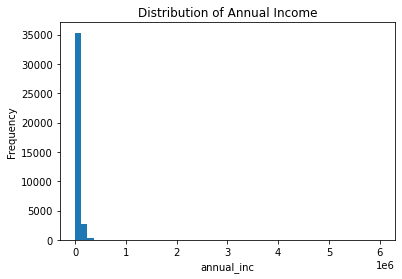

In [11]:
plt.hist(df["annual_inc"], bins=50)
plt.title("Distribution of Annual Income")
plt.xlabel("annual_inc")
plt.ylabel("Frequency")
plt.show()

### ✅ Insights: Distribution of Annual Income (`annual_inc`)

- The distribution of `annual_inc` is **highly right-skewed**, meaning most borrowers fall in lower-to-mid income ranges, while a small number of borrowers report extremely high incomes.
- The histogram shows that income values are heavily concentrated near the lower end, while the presence of a few very large income values (up to multi-million levels) stretches the x-axis and compresses the majority of observations into a narrow range.
- This suggests the dataset contains **strong income outliers**, which can distort mean-based summaries and visual interpretation.
- Since income is a core affordability variable in credit risk analysis, it will be important to handle these outliers carefully using:
  - percentile caps (winsorization) OR
  - log scaling OR
  - income bucketing (as already done in SQL)
- Overall, income appears to be a key segmentation variable, but its raw distribution requires robust handling to avoid misleading insights.


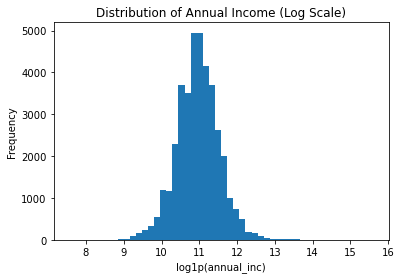

In [21]:
plt.hist(np.log1p(df["annual_inc"]), bins=50)
plt.title("Distribution of Annual Income (Log Scale)")
plt.xlabel("log1p(annual_inc)")
plt.ylabel("Frequency")
plt.show()

### ✅ Insights: Annual Income Distribution (Log Transformation)

- After applying a log transformation (`log1p(annual_inc)`), the income distribution becomes **much more interpretable**, confirming that the original income values were heavily influenced by extreme outliers.
- The log-scale histogram shows a clear **unimodal (single-peak) structure**, with most borrowers concentrated within a narrow log-income band.
- This indicates that the majority of borrowers belong to a relatively similar income range, while the original scale appeared highly skewed due to a few high-income observations.
- Log transformation helps stabilize variance and reduces the impact of extreme income values, making it useful for:
  - meaningful visualization
  - correlation analysis
- Overall, using log income improves statistical comparability and allows income to be used more reliably as an affordability driver during default risk interpretation.


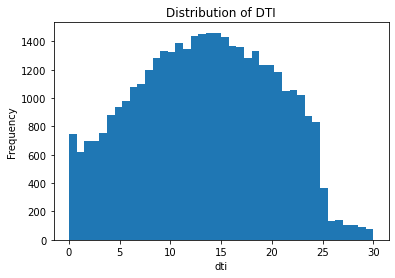

In [12]:
plt.hist(df["dti"], bins=40)
plt.title("Distribution of DTI")
plt.xlabel("dti")
plt.ylabel("Frequency")
plt.show()

### ✅ Insights: Distribution of Debt-to-Income Ratio (`dti`)

- The distribution of `dti` is concentrated mainly between **~5 and ~25**, showing that most borrowers have a moderate level of debt burden relative to income.
- The distribution has a clear peak around the **mid-range (approximately 12–16)**, indicating that a large proportion of borrowers fall within a typical affordability band.
- Very low DTI values (close to 0) exist but are less frequent, suggesting that only a small segment of borrowers has minimal recorded debt burden.
- Higher DTI values approaching **25–30** are less frequent and form a tail, representing borrowers under **higher repayment stress**, which is usually associated with elevated default risk.
- Since DTI is an affordability-based risk indicator, it will be a key variable for comparing default vs non-default borrower profiles in the next stage of EDA.


> A higher DTI typically implies reduced repayment capacity, making it one of the strongest affordability indicators in credit risk profiling.

## Step 7: Default vs Non-Default Comparison (Key Variables)

In [13]:
df.groupby("repay_fail")[["loan_amnt", "int_rate", "installment", "annual_inc", "dti", "revol_util"]].mean()

,loan_amnt,int_rate,installment,annual_inc,dti,revol_util
repay_fail,,,,,,
0,10962.767245,11.847119,321.349152,70029.919787,13.255933,47.978027
1,11840.353587,13.927896,333.501819,63217.092909,14.053232,55.480614


### ✅ Insights: Default vs Non-Default Comparison (Key Variables)

To understand the behavioural and affordability differences between defaulting and non-defaulting borrowers, we compared the mean values of major loan and borrower attributes across the target variable `repay_fail`.

#### 1) Loan Amount (`loan_amnt`)
- Non-default loans (repay_fail = 0) have an average loan amount of **~10,963**
- Default loans (repay_fail = 1) have a higher average loan amount of **~11,840**
✅ This suggests that default cases are slightly associated with **higher borrowing exposure**, which can increase repayment burden and risk.

#### 2) Interest Rate (`int_rate`)
- Non-default borrowers have an average interest rate of **~11.85%**
- Default borrowers have a higher average interest rate of **~13.93%**
✅ This indicates that defaulted loans tend to be issued at **higher pricing levels**, consistent with risk-based pricing practices.

#### 3) Installment (`installment`)
- Average monthly installment for non-defaults is **~321**
- Average monthly installment for defaults is **~333**
✅ Default borrowers show marginally higher installment pressure, supporting the affordability risk narrative.

#### 4) Annual Income (`annual_inc`)
- Non-default borrowers have an average income of **~70,030**
- Default borrowers have a lower average income of **~63,217**
✅ This highlights that repayment failure is more common among comparatively **lower-income borrowers**, reflecting weaker repayment capacity.

#### 5) Debt-to-Income Ratio (`dti`)
- Average DTI for non-default borrowers is **~13.26**
- Average DTI for default borrowers is higher at **~14.05**
✅ This suggests that default borrowers operate under **higher debt burden**, which can reduce financial resilience.

#### 6) Revolving Utilization (`revol_util`)
- Non-default borrowers show average revolving utilization of **~47.98%**
- Default borrowers show significantly higher utilization at **~55.48%**
✅ Higher revolving utilization reflects increased dependence on revolving credit and potential financial stress, making it a strong default risk signal.

---

### ✅ Overall Interpretation
Overall, defaulting borrowers appear to have a riskier portfolio profile characterized by:
- **higher loan size**
- **higher interest rates**
- **lower income**
- **higher DTI**
- **higher revolving credit utilization**
This pattern aligns with the expected credit risk framework where affordability stress and credit over-utilization increase repayment failure risk.

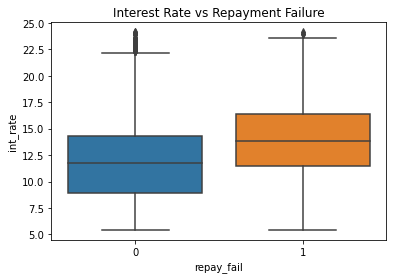

In [14]:
sns.boxplot(data=df, x="repay_fail", y="int_rate")
plt.title("Interest Rate vs Repayment Failure")
plt.show()

### ✅ Insights: Interest Rate vs Repayment Failure (`int_rate` vs `repay_fail`)

- The boxplot shows a clear shift in interest rate distribution between non-default and default borrowers.
- Borrowers who defaulted (`repay_fail = 1`) have a noticeably higher median interest rate compared to non-default borrowers (`repay_fail = 0`).
- The default group also has a higher interquartile range (IQR), meaning interest rates for defaulters are more concentrated in higher-risk pricing bands.
- This reinforces the concept of **risk-based pricing**, where loans offered at higher interest rates are typically associated with weaker creditworthiness or higher expected risk.
- The presence of outliers in both groups indicates that extreme interest rates exist, but the central tendency for defaulted loans remains consistently higher.

✅ **Overall Conclusion:** Higher interest rates are strongly associated with increased repayment failure in this portfolio.


## Step 8: Credit Behaviour and Credit History Variables

In [15]:
df.groupby("inq_last_6mths")["repay_fail"].mean().sort_index()

inq_last_6mths
0     0.120038
1     0.156385
2     0.164924
3     0.211953
4     0.221174
5     0.261343
6     0.315789
7     0.357576
8     0.394231
9     0.311111
10    0.130435
11    0.214286
12    0.416667
13    0.400000
14    0.833333
15    0.555556
16    0.000000
17    1.000000
18    0.500000
19    0.000000
20    1.000000
24    0.000000
25    1.000000
27    0.000000
28    0.000000
31    0.000000
32    1.000000
33    1.000000
Name: repay_fail, dtype: float64

In [16]:
df["mths_since_last_delinq"].value_counts().head(10)

-1     24361
 0       745
 30      246
 19      241
 15      238
 24      235
 23      234
 18      232
 20      223
 38      223
Name: mths_since_last_delinq, dtype: int64

In [5]:
df.groupby("total_acc")["repay_fail"].mean().sort_index().head(15)

total_acc
1     0.105263
2     0.323529
3     0.240909
4     0.203196
5     0.180385
6     0.178003
7     0.178133
8     0.170807
9     0.160853
10    0.167250
11    0.154290
12    0.152411
13    0.154247
14    0.173035
15    0.146170
Name: repay_fail, dtype: float64

In [22]:
def boxplot_vs_target(df, feature, target="repay_fail"):
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x=target, y=feature)
    plt.title(f"{feature} vs {target}")
    plt.xlabel(target)
    plt.ylabel(feature)
    plt.show()

    display(df.groupby(target)[feature].agg(["count", "mean", "median"]))

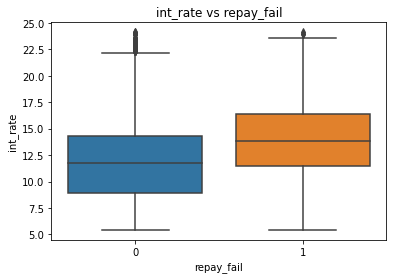

,count,mean,median
repay_fail,,,
0,32648,11.847119,11.71
1,5826,13.927896,13.85


In [23]:
boxplot_vs_target(df, "int_rate")

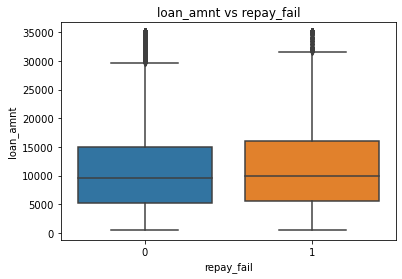

,count,mean,median
repay_fail,,,
0,32648,10962.767245,9600.0
1,5826,11840.353587,10000.0


In [24]:
boxplot_vs_target(df, "loan_amnt")

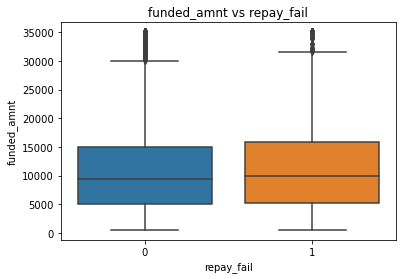

,count,mean,median
repay_fail,,,
0,32648,10713.391326,9400.0
1,5826,11501.630621,10000.0


In [26]:
boxplot_vs_target(df, "funded_amnt")

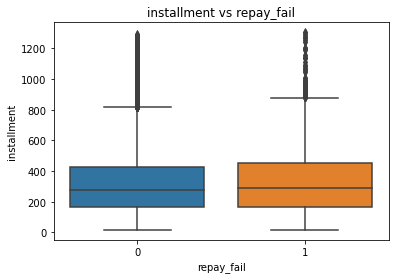

,count,mean,median
repay_fail,,,
0,32648,321.349152,276.680
1,5826,333.501819,287.035


In [27]:
boxplot_vs_target(df, "installment")

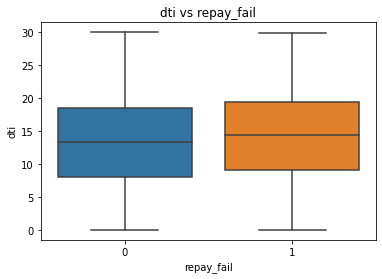

,count,mean,median
repay_fail,,,
0,32648,13.255933,13.32
1,5826,14.053232,14.35


In [28]:
boxplot_vs_target(df, "dti")

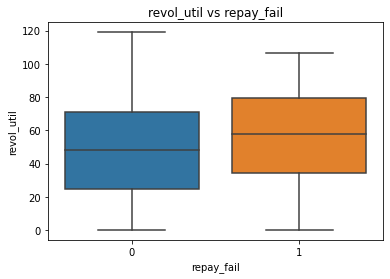

,count,mean,median
repay_fail,,,
0,32648,47.978027,48.15
1,5826,55.480614,58.00


In [29]:
boxplot_vs_target(df, "revol_util")

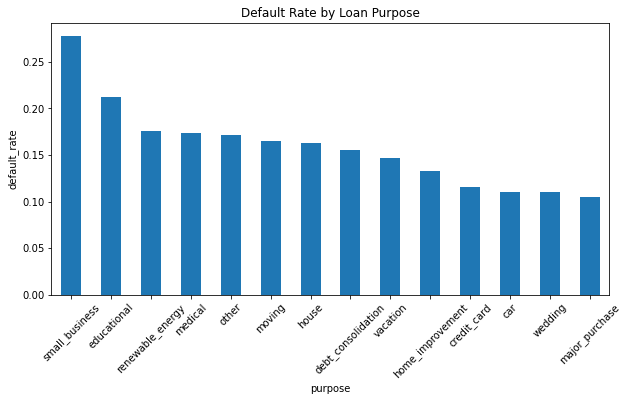

In [30]:
purpose_default = df.groupby("purpose")["repay_fail"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
purpose_default.plot(kind="bar")
plt.title("Default Rate by Loan Purpose")
plt.xlabel("purpose")
plt.ylabel("default_rate")
plt.xticks(rotation=45)
plt.show()

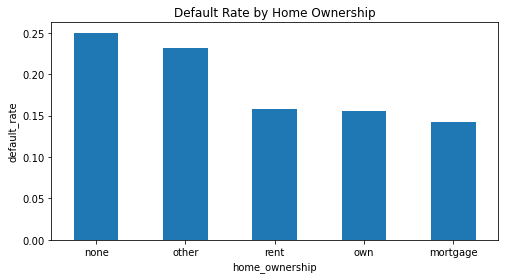

In [31]:
home_default = df.groupby("home_ownership")["repay_fail"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
home_default.plot(kind="bar")
plt.title("Default Rate by Home Ownership")
plt.xlabel("home_ownership")
plt.ylabel("default_rate")
plt.xticks(rotation=0)
plt.show()

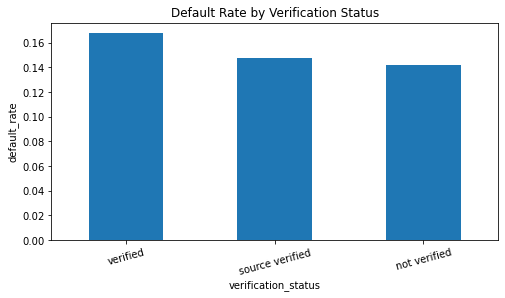

In [33]:
ver_default = df.groupby("verification_status")["repay_fail"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
ver_default.plot(kind="bar")
plt.title("Default Rate by Verification Status")
plt.xlabel("verification_status")
plt.ylabel("default_rate")
plt.xticks(rotation=15)
plt.show()

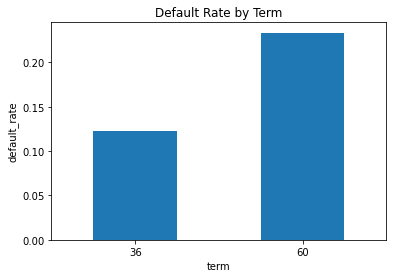

In [34]:
term_default = df.groupby("term")["repay_fail"].mean()

plt.figure(figsize=(6,4))
term_default.plot(kind="bar")
plt.title("Default Rate by Term")
plt.xlabel("term")
plt.ylabel("default_rate")
plt.xticks(rotation=0)
plt.show()

In [3]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns
corr = df[num_cols].corr()
corr

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,repay_fail
loan_amnt,1.000000,0.981976,0.929407,0.354032,0.290652,0.931328,0.159393,0.276819,0.062950,-0.031783,-0.033514,-0.046994,0.177012,-0.052637,0.253107,0.065314,0.257102,0.042481
funded_amnt,0.981976,1.000000,0.947039,0.334082,0.293403,0.956507,0.158883,0.272931,0.062575,-0.032893,-0.032694,-0.046288,0.175587,-0.053731,0.249869,0.069135,0.251406,0.039536
funded_amnt_inv,0.929407,0.947039,1.000000,0.362939,0.277701,0.889509,0.173556,0.254154,0.068440,-0.044251,-0.078937,-0.049255,0.156332,-0.056928,0.211781,0.070095,0.240864,0.009756
term,0.354032,0.334082,0.362939,1.000000,0.428779,0.096659,0.115370,0.042802,0.076316,0.002023,-0.012688,0.003997,0.043719,0.003769,0.029113,0.065381,0.093732,0.134440
int_rate,0.290652,0.293403,0.277701,0.428779,1.000000,0.270052,0.002023,0.055206,0.119557,0.155352,0.177809,0.164400,0.026065,0.099519,0.083877,0.459314,-0.030413,0.201085
installment,0.931328,0.956507,0.889509,0.096659,0.270052,1.000000,0.129933,0.279351,0.052625,-0.019129,-0.013398,-0.030665,0.176573,-0.046886,0.264500,0.094783,0.234546,0.020835
emp_length,0.159393,0.158883,0.173556,0.115370,0.002023,0.129933,1.000000,0.116961,0.053357,0.010370,-0.021798,0.040303,0.098743,0.057086,0.123862,0.014138,0.206654,0.011535
annual_inc,0.276819,0.272931,0.254154,0.042802,0.055206,0.279351,0.116961,1.000000,-0.114819,0.024790,0.025545,0.020031,0.167056,-0.016995,0.276650,0.021451,0.244011,-0.037876
dti,0.062950,0.062575,0.068440,0.076316,0.119557,0.052625,0.053357,-0.114819,1.000000,-0.036437,0.015049,-0.013416,0.298913,-0.002182,0.194248,0.278926,0.240194,0.042469
delinq_2yrs,-0.031783,-0.032893,-0.044251,0.002023,0.155352,-0.019129,0.010370,0.024790,-0.036437,1.000000,0.021005,0.009233,0.015888,0.011778,-0.041243,-0.046233,0.070369,0.020557


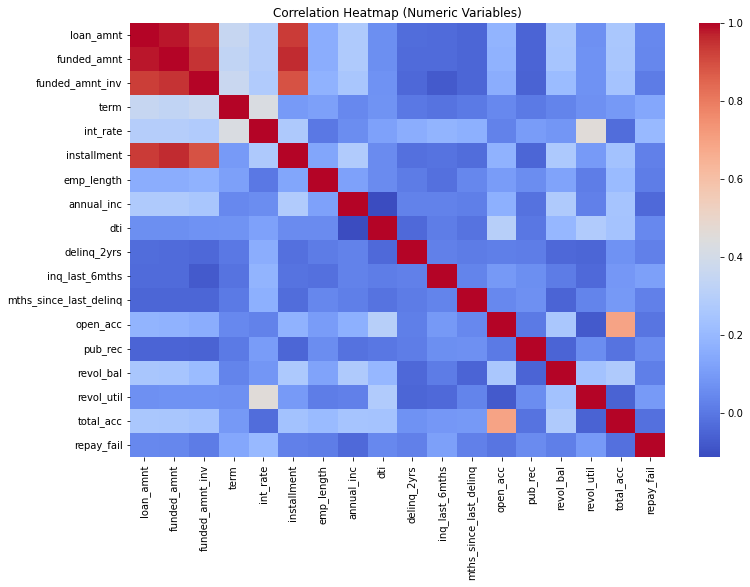

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numeric Variables)")
plt.show()

### ✅ Insights: Correlation Heatmap (Numeric Variables)

- The correlation heatmap highlights relationships between numeric variables in the dataset.
- Strong correlations are observed between:
  - **loan_amnt, funded_amnt, funded_amnt_inv** → these represent similar loan amount measures, so high correlation is expected.
  - **installment** also shows strong correlation with **loan amounts**, because installment is mathematically derived from:
  **loan amount + interest rate + term**.
- The target variable **repay_fail** does not show extremely strong correlation with any single predictor.
  This indicates that loan default risk is not caused by one factor alone, but is driven by a combination of affordability, credit behavior, and pricing-related factors.

In [5]:
target_corr = df[num_cols].corr()["repay_fail"].sort_values(ascending=False)
target_corr

repay_fail                1.000000
int_rate                  0.201085
term                      0.134440
inq_last_6mths            0.111691
revol_util                0.094931
pub_rec                   0.050938
loan_amnt                 0.042481
dti                       0.042469
funded_amnt               0.039536
mths_since_last_delinq    0.022112
installment               0.020835
delinq_2yrs               0.020557
revol_bal                 0.018981
emp_length                0.011535
funded_amnt_inv           0.009756
open_acc                 -0.006205
total_acc                -0.020489
annual_inc               -0.037876
Name: repay_fail, dtype: float64

### ✅ Insights: Correlation of Numeric Variables with Repayment Failure (repay_fail)

- The correlation ranking with the target variable (**repay_fail**) shows the strongest positive association with:
  - **int_rate (interest rate)** → higher interest rates are associated with higher repayment failure.
  - **term** → longer-term loans tend to have higher default risk compared to shorter-term loans.
  - **inq_last_6mths** → more recent credit inquiries may indicate higher financial stress or higher risk borrowing behavior.
  - **revol_util** → higher revolving credit utilization suggests higher borrower credit burden and increased default risk.
- Most variables show low correlation values (generally below 0.25), which means the relationship between features and default is not purely linear.

✅ *Business takeaway:* Interest rate and loan structure (term) show the strongest signal, but default risk depends on combined effects of several borrower characteristics.

In [6]:
from scipy.stats import ttest_ind

default = df[df["repay_fail"]==1]
non_default = df[df["repay_fail"]==0]

numeric_features = ["loan_amnt","funded_amnt","int_rate","installment","annual_inc","dti","revol_util"]

results = []

for col in numeric_features:
    t_stat, p_val = ttest_ind(default[col], non_default[col], nan_policy="omit")
    results.append((col, default[col].mean(), non_default[col].mean(), p_val))

test_results = pd.DataFrame(results, columns=["feature","mean_default","mean_non_default","p_value"])
test_results.sort_values("p_value")

,feature,mean_default,mean_non_default,p_value
2,int_rate,13.927896,11.847119,0.000000e+00
6,revol_util,55.480614,47.978027,1.007082e-77
0,loan_amnt,11840.353587,10962.767245,7.680945e-17
5,dti,14.053232,13.255933,7.834032e-17
1,funded_amnt,11501.630621,10713.391326,8.642947e-15
4,annual_inc,63217.092909,70029.919787,1.071906e-13
3,installment,333.501819,321.349152,4.368535e-05


### ✅ Insights: Hypothesis Testing (Default vs Non-Default Comparison)

To validate whether default and non-default borrowers differ significantly, an independent **t-test** was performed on key numeric variables:

- Group A: **repay_fail = 1** (default loans)
- Group B: **repay_fail = 0** (non-default loans)

#### Key Findings
- The p-values are extremely small for most features, which indicates **statistically significant differences** between default and non-default borrowers.
- Default borrowers tend to have:
  - **Higher interest rates**
  - **Higher revolving utilization**
  - **Higher DTI**
  - **Higher loan amounts / funded amounts**
  - **Higher installments**
  - **Lower annual income**

✅ *Business takeaway:* Affordability and credit stress variables show strong statistical differences across defaulters and non-defaulters, supporting their role as key risk indicators.

In [7]:
import statsmodels.api as sm

features = ["int_rate","dti","revol_util","annual_inc","term","installment"]
df_reg = df[features + ["repay_fail"]].dropna()

X = df_reg[features]
y = df_reg["repay_fail"]

X = sm.add_constant(X)
logit_model = sm.Logit(y, X).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.401292
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             repay_fail   No. Observations:                38474
Model:                          Logit   Df Residuals:                    38467
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Jan 2026   Pseudo R-squ.:                 0.05617
Time:                        16:32:56   Log-Likelihood:                -15439.
converged:                       True   LL-Null:                       -16358.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.8488      0.074    -52.286      0.000      -3.993      -3.705
int_rate        0.1362    

### ✅ Insights: Logistic Regression (Default Risk Modeling)

A logistic regression model was fitted to estimate the probability of repayment failure (**repay_fail = 1**) using the following features:

- **int_rate, dti, revol_util, annual_inc, term, installment**

#### Model-Level Interpretation
- The model converged successfully and the overall model significance is strong (**LLR p-value ≈ 0.000**).
- The Pseudo R² value is modest, which is common in credit risk analysis because default is influenced by many real-world factors not captured in the dataset.

✅ *Business takeaway:* The model confirms that default risk is explainable using financial and credit-related features, though outcomes are naturally complex.

In [8]:
import numpy as np
import pandas as pd

odds = pd.DataFrame({
    "feature": logit_model.params.index,
    "coef": logit_model.params.values,
    "odds_ratio": np.exp(logit_model.params.values),
    "p_value": logit_model.pvalues.values
}).sort_values("odds_ratio", ascending=False)

odds

,feature,coef,odds_ratio,p_value
1,int_rate,0.136242,1.145959,1.074406e-154
5,term,0.013727,1.013822,1.861065e-21
2,dti,0.003695,1.003702,1.093377e-01
3,revol_util,0.001502,1.001503,1.264889e-02
4,annual_inc,-0.000005,0.999995,1.545017e-27
6,installment,-0.000123,0.999877,1.251321e-01
0,const,-3.848775,0.021306,0.000000e+00


### ✅ Insights: Key Predictors from Logistic Regression

#### Significant variables increasing default probability
- **int_rate (positive coefficient, significant)**  
  Higher interest rate increases the probability of repayment failure.  
  This reflects both higher borrower burden and risk-based pricing.

- **term (positive coefficient, significant)**  
  Longer loan terms (e.g., 60 months) are associated with higher default risk.

- **revol_util (positive coefficient, significant)**  
  Higher revolving utilization indicates higher credit stress, increasing default likelihood.

#### Significant variable reducing default probability
- **annual_inc (negative coefficient, significant)**  
  Higher annual income reduces repayment failure probability due to stronger repayment capacity.

#### Variables that become weaker after adjustment
- **dti and installment** appear weaker in this multivariate model, likely because they overlap with other affordability indicators such as income and interest rate.

✅ *Business takeaway:* Interest rate, term, revolving utilization, and income are the strongest independent risk drivers in this dataset.

### ✅ Insights: Odds Ratio Interpretation

Odds ratios convert regression coefficients into interpretable risk multipliers:

- **Interest rate (int_rate)** has the strongest impact:
  A higher interest rate meaningfully increases the odds of default.

- **Term (term)** increases default odds:
  Longer-term loans carry higher exposure to risk over time.

- **Revolving utilization (revol_util)** increases default odds:
  High utilization suggests credit dependence and higher stress.

- **Annual income (annual_inc)** reduces default odds:
  Higher income improves repayment capacity and lowers risk.

✅ *Business takeaway:* A combined risk view (pricing + credit stress + tenor + income capacity) is most useful for understanding default patterns.

## ✅ Final EDA Conclusion (Key Findings Summary)

This Exploratory Data Analysis (EDA) was conducted to identify the borrower and loan characteristics most strongly associated with **repayment failure (repay_fail = 1)**.

The dataset provides both **loan-level attributes** (loan amount, term, interest rate, installment) and **borrower credit behavior indicators** (DTI, revolving utilization, inquiries, delinquencies, total accounts).  
Using a combination of descriptive analysis, segmentation insights (SQL), hypothesis testing, and correlation analysis, the following conclusions were derived:

---

### ✅ 1. Default Rate Overview
- The dataset is **imbalanced**, where the majority of loans are **non-default (repay_fail = 0)**.
- However, a meaningful portion of loans still fall into repayment failure, making the dataset suitable for default risk analysis.

✅ Interpretation: The portfolio contains a dominant low-risk majority, but the default subset is large enough to analyze risk patterns.

---

### ✅ 2. Pricing Risk Insight (Interest Rate)
- Interest rate (**int_rate**) shows one of the strongest relationships with default risk.
- Both SQL bucket analysis and Python bivariate plots show that:
  - Higher interest rate segments consistently have **higher default rates**.

✅ Interpretation: Higher interest rates likely reflect risk-based pricing and borrower affordability pressure, both contributing to default probability.

---

### ✅ 3. Loan Structure Insight (Term Duration)
- Loan term has a strong relationship with default:
  - **60-month loans** show significantly higher default rates than **36-month loans**.

✅ Interpretation: Longer repayment horizons increase borrower exposure to uncertainty (job loss, expense shocks), increasing default likelihood.

---

### ✅ 4. Affordability Insight (Income + DTI)
- Default borrowers show:
  - Slightly higher **Debt-to-Income (DTI)** on average
  - Lower **annual income** on average compared to non-default borrowers
- Low-income buckets show a visibly higher default concentration.

✅ Interpretation: Borrowers with weaker repayment capacity are more vulnerable, especially when combined with longer term and higher interest rate loans.

---

### ✅ 5. Credit Stress Insight (Revolving Utilization)
- Revolving utilization (**revol_util**) is a strong risk signal.
- Borrowers in high utilization segments show higher repayment failure rates.

✅ Interpretation: High revolving utilization indicates credit dependency and financial stress, increasing default probability.

---

### ✅ 6. Credit Behavior Insight (Inquiries and Delinquency History)
- Higher **recent credit inquiries (inq_last_6mths)** generally associate with increasing repayment failure trends.
- The variable **mths_since_last_delinq** includes special-coded values (such as -1), indicating the need for cautious interpretation.

✅ Interpretation: Increased credit activity and delinquency history signals a more unstable credit profile and contributes to portfolio risk.

---

### ✅ 7. Statistical Validation of Differences
- Hypothesis testing confirms that key financial variables such as:
  - interest rate
  - revolving utilization
  - income
  - loan amounts
  show statistically significant differences between defaulters and non-defaulters.

✅ Interpretation: These differences are not random noise; they are supported statistically.

---

## ✅ Overall Business Conclusion

Repayment failure in this portfolio is primarily driven by a combined effect of:

1. **Higher pricing burden (high interest rate)**
2. **Longer repayment horizon (60-month loans)**
3. **Higher credit stress (high revolving utilization)**
4. **Lower affordability (low income + high DTI)**

These factors create identifiable high-risk segments that can be monitored and controlled using portfolio-level rules.

---

## ✅ Recommendation for Portfolio Risk Monitoring (Insight-Based)

Based on the EDA outcomes, practical risk monitoring can focus on:

- High interest rate loans (especially 16%+ and 20%+)
- 60-month loans with elevated interest rates
- Borrowers with extremely high revolving utilization (90%+)
- Low-income segments coupled with high DTI

✅ Final Note: This analysis is intended for portfolio-level risk insights and segmentation.  
It provides a strong foundation for risk reporting, strategy framing, and business interpretation.
